In [26]:

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle


# Creating and training model

## Train and Test data

In [5]:
# train
trainDataRaw = pd.read_csv('../../../datasets/fraudTrain.csv')
print(trainDataRaw.shape)
print(trainDataRaw.head())

(1296675, 23)
   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   
3           3   2019-01-01 00:01:16  3534093764340240   
4           4   2019-01-01 00:03:06   375534208663984   

                             merchant       category     amt      first  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie   
2                fraud_Lind-Buckridge  entertainment  220.11     Edward   
3  fraud_Kutch, Hermiston and Farrell  gas_transport   45.00     Jeremy   
4                 fraud_Keeling-Crist       misc_pos   41.96      Tyler   

      last gender                        street  ...      lat      long  \
0    Banks      F                561 Perry Cove  ...  36.0788  -81.1781   
1     Gill      F  43039 Riley Greens Suit

In [6]:
# test
testDataRaw = pd.read_csv('../../../datasets/fraudTest.csv')
print(testDataRaw.shape)
print(testDataRaw.head())

(555719, 23)
   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2020-06-21 12:14:25  2291163933867244   
1           1   2020-06-21 12:14:33  3573030041201292   
2           2   2020-06-21 12:14:53  3598215285024754   
3           3   2020-06-21 12:15:15  3591919803438423   
4           4   2020-06-21 12:15:17  3526826139003047   

                               merchant        category    amt   first  \
0                 fraud_Kirlin and Sons   personal_care   2.86    Jeff   
1                  fraud_Sporer-Keebler   personal_care  29.84  Joanne   
2  fraud_Swaniawski, Nitzsche and Welch  health_fitness  41.28  Ashley   
3                     fraud_Haley Group        misc_pos  60.05   Brian   
4                 fraud_Johnston-Casper          travel   3.19  Nathan   

       last gender                       street  ...      lat      long  \
0   Elliott      M            351 Darlene Green  ...  33.9659  -80.9355   
1  Williams      F             3638 Marsh Union  

## Visualizing Data

In [8]:
print(trainDataRaw['is_fraud'].value_counts())

is_fraud
0    1289169
1       7506
Name: count, dtype: int64


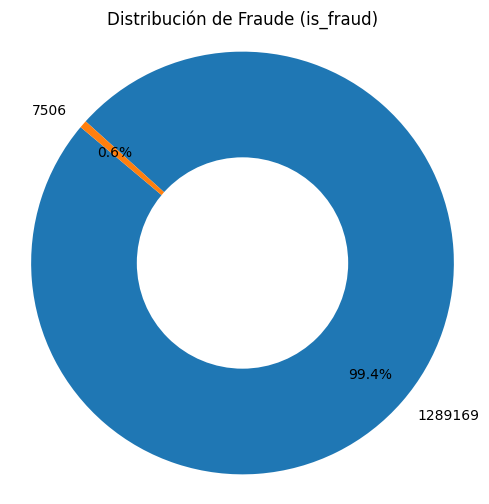

In [9]:
piecito = trainDataRaw['is_fraud'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(piecito, labels=piecito, autopct='%1.1f%%', pctdistance=0.8 , startangle=140)

cir = plt.Circle((0.0, 0.0), 0.5, fc='white')
fig = plt.gcf()
fig.gca().add_artist(cir)

plt.title('Distribución de Fraude (is_fraud)')
plt.axis('equal') 

plt.show()


## Data cleaning (trainData)

In [10]:
columns_out = ['Unnamed: 0', 'cc_num', 'merchant', 'state', 'first', 'last', 'gender', 'street', 'city', 'zip', 'city', 'job', 'dob', 'trans_num', 'unix_time']

In [11]:
trainData = trainDataRaw.drop(columns=columns_out)
testData = testDataRaw.drop(columns=columns_out)

In [12]:
print(trainData.shape)
print(testData.shape)

(1296675, 9)
(555719, 9)


## Data Cleaning

In [13]:
# Category encoding
Xtrain = pd.get_dummies(trainData, columns=['category'], prefix='cat')
Xtrain = Xtrain.drop(columns=['is_fraud'])
# Date encoding
Xtrain['hour'] = pd.to_datetime(trainData['trans_date_trans_time']).dt.hour
Xtrain['day'] = pd.to_datetime(trainData['trans_date_trans_time']).dt.day_of_week
Xtrain['month'] = pd.to_datetime(trainData['trans_date_trans_time']).dt.month
Xtrain = Xtrain.drop(columns=['trans_date_trans_time'])
print(Xtrain.shape)

(1296675, 23)


In [14]:
Xtrain.head()

,amt,lat,long,city_pop,merch_lat,merch_long,cat_entertainment,cat_food_dining,cat_gas_transport,cat_grocery_net,...,cat_kids_pets,cat_misc_net,cat_misc_pos,cat_personal_care,cat_shopping_net,cat_shopping_pos,cat_travel,hour,day,month
0,4.97,36.0788,-81.1781,3495,36.011293,-82.048315,False,False,False,False,...,False,True,False,False,False,False,False,0,1,1
1,107.23,48.8878,-118.2105,149,49.159047,-118.186462,False,False,False,False,...,False,False,False,False,False,False,False,0,1,1
2,220.11,42.1808,-112.2620,4154,43.150704,-112.154481,True,False,False,False,...,False,False,False,False,False,False,False,0,1,1
3,45.00,46.2306,-112.1138,1939,47.034331,-112.561071,False,False,True,False,...,False,False,False,False,False,False,False,0,1,1
4,41.96,38.4207,-79.4629,99,38.674999,-78.632459,False,False,False,False,...,False,False,True,False,False,False,False,0,1,1


In [15]:
ytrain = trainData['is_fraud']
print(ytrain.head())
print(ytrain.shape)

0    0
1    0
2    0
3    0
4    0
Name: is_fraud, dtype: int64
(1296675,)


In [16]:
Xtrain.shape

(1296675, 23)

## Undersampling and Oversampling

In [17]:
# Undersampling 
under_sampling = RandomUnderSampler(sampling_strategy=1, random_state=42)

In [18]:
# Undersampling fitting
X_under, y_under = under_sampling.fit_resample(Xtrain, ytrain)

In [19]:
resampled_data = pd.concat([pd.DataFrame(X_under, columns=Xtrain.columns), pd.Series(y_under, name='is_fraud')], axis=1)

In [20]:
# Oversampling
over_sampling = RandomOverSampler(sampling_strategy=0.5, random_state=42)

In [21]:
# Oversampling fitting
X_over, y_over = over_sampling.fit_resample(Xtrain, ytrain)

In [22]:
resampled_data = pd.concat([pd.DataFrame(X_over, columns=Xtrain.columns), pd.Series(y_over, name='is_fraud')], axis=1)

In [25]:
resampled_data.head()

,amt,lat,long,city_pop,merch_lat,merch_long,cat_entertainment,cat_food_dining,cat_gas_transport,cat_grocery_net,...,cat_misc_net,cat_misc_pos,cat_personal_care,cat_shopping_net,cat_shopping_pos,cat_travel,hour,day,month,is_fraud
0,4.97,36.0788,-81.1781,3495,36.011293,-82.048315,False,False,False,False,...,True,False,False,False,False,False,0,1,1,0
1,107.23,48.8878,-118.2105,149,49.159047,-118.186462,False,False,False,False,...,False,False,False,False,False,False,0,1,1,0
2,220.11,42.1808,-112.2620,4154,43.150704,-112.154481,True,False,False,False,...,False,False,False,False,False,False,0,1,1,0
3,45.00,46.2306,-112.1138,1939,47.034331,-112.561071,False,False,True,False,...,False,False,False,False,False,False,0,1,1,0
4,41.96,38.4207,-79.4629,99,38.674999,-78.632459,False,False,False,False,...,False,True,False,False,False,False,0,1,1,0


In [29]:
resampled_data = shuffle(resampled_data, random_state=42)

In [30]:
resampled_data.head()

,amt,lat,long,city_pop,merch_lat,merch_long,cat_entertainment,cat_food_dining,cat_gas_transport,cat_grocery_net,...,cat_misc_net,cat_misc_pos,cat_personal_care,cat_shopping_net,cat_shopping_pos,cat_travel,hour,day,month,is_fraud
440633,28.45,40.7641,-84.0973,86954,40.038407,-84.402497,False,False,False,False,...,False,False,False,False,False,False,9,0,7,0
1651068,12.10,36.8421,-85.5396,341,36.156708,-85.788662,False,False,False,True,...,False,False,False,False,False,False,7,2,10,1
573944,7.71,33.3398,-92.7442,2501,33.331356,-91.991665,False,False,False,False,...,False,False,False,False,False,True,23,5,8,0
364493,7.23,37.0581,-86.1938,6841,36.450273,-85.755675,False,False,False,False,...,False,False,False,True,False,False,22,0,6,0
703788,49.67,34.7437,-102.5064,53,34.840229,-103.374224,False,False,False,False,...,False,False,False,False,False,False,15,6,10,0


In [32]:
print(resampled_data['is_fraud'].value_counts())

is_fraud
0    1289169
1     644584
Name: count, dtype: int64


## Training the model

In [34]:
Xtrain = resampled_data.drop(columns=['is_fraud'])
print(Xtrain.shape)

(1933753, 23)


In [35]:
ytrain = resampled_data['is_fraud']
print(ytrain.head())
print(ytrain.shape)

440633     0
1651068    1
573944     0
364493     0
703788     0
Name: is_fraud, dtype: int64
(1933753,)


In [36]:
X, Xtest, y, ytest = train_test_split(Xtrain, ytrain, test_size=0.25, random_state=42, stratify=ytrain)

scaler = StandardScaler()
X = scaler.fit_transform(X)
Xtest = scaler.transform(Xtest)

In [37]:
# Modelo feed-forward
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=32, activation='relu', input_dim=X.shape[1]),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
# X.shape[1] = 23

In [38]:
# Learning rate for RMSprop
lr = 0.0001
optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)

In [39]:
# Compile
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                768       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 9153 (35.75 KB)
Trainable params: 9153 (35.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [40]:
# Train 
model.fit(X, y, epochs=5, batch_size=16, validation_data=(Xtest, ytest))
model.save('detectorV5.h5')

Epoch 1/5
90645/90645 [==============================] - 158s 2ms/step - loss: 0.1536 - accuracy: 0.9403 - val_loss: 0.1170 - val_accuracy: 0.9547
Epoch 2/5
90645/90645 [==============================] - 161s 2ms/step - loss: 0.1137 - accuracy: 0.9562 - val_loss: 0.1255 - val_accuracy: 0.9526
Epoch 3/5
90645/90645 [==============================] - 144s 2ms/step - loss: 0.1164 - accuracy: 0.9573 - val_loss: 0.1567 - val_accuracy: 0.9538
Epoch 4/5
90645/90645 [==============================] - 149s 2ms/step - loss: 0.1194 - accuracy: 0.9571 - val_loss: 0.1063 - val_accuracy: 0.9582
Epoch 5/5
90645/90645 [==============================] - 171s 2ms/step - loss: 0.1251 - accuracy: 0.9565 - val_loss: 0.1209 - val_accuracy: 0.9609


c:\Users\U S U A R I O\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [41]:
# Evaluate the model
predict = model.predict(Xtest)

15108/15108 [==============================] - 14s 933us/step


In [42]:
predict = (predict > 0.5) # if prob > 0.5 is fraud and vice versa

In [43]:
# Confusion matrix 
confusion = confusion_matrix(ytest, predict)
print("Confusion Matrix:")
print(confusion)
# Correct 0 - Incorrect 1
# Incorrect 0 - Correct 1

Confusion Matrix:
[[312457   9836]
 [  9076 152070]]


In [44]:
# Classification report
report = classification_report(ytest, predict)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97    322293
           1       0.94      0.94      0.94    161146

    accuracy                           0.96    483439
   macro avg       0.96      0.96      0.96    483439
weighted avg       0.96      0.96      0.96    483439



# Model Checking

In [45]:
print(testDataRaw.shape)
print(testData.shape)

(555719, 23)
(555719, 9)


In [46]:
# Category encoding
XtestCheck = pd.get_dummies(testData, columns=['category'], prefix=['cat'])
XtestCheck = XtestCheck.drop(columns=['is_fraud'])
# Date encoding
XtestCheck['hour'] = pd.to_datetime(testData['trans_date_trans_time']).dt.hour
XtestCheck['day'] = pd.to_datetime(testData['trans_date_trans_time']).dt.day_of_week
XtestCheck['month'] = pd.to_datetime(testData['trans_date_trans_time']).dt.month
XtestCheck = XtestCheck.drop(columns=['trans_date_trans_time'])
print(XtestCheck.shape)

(555719, 23)


In [47]:
XtestCheck.head()

,amt,lat,long,city_pop,merch_lat,merch_long,cat_entertainment,cat_food_dining,cat_gas_transport,cat_grocery_net,...,cat_kids_pets,cat_misc_net,cat_misc_pos,cat_personal_care,cat_shopping_net,cat_shopping_pos,cat_travel,hour,day,month
0,2.86,33.9659,-80.9355,333497,33.986391,-81.200714,False,False,False,False,...,False,False,False,True,False,False,False,12,6,6
1,29.84,40.3207,-110.4360,302,39.450498,-109.960431,False,False,False,False,...,False,False,False,True,False,False,False,12,6,6
2,41.28,40.6729,-73.5365,34496,40.495810,-74.196111,False,False,False,False,...,False,False,False,False,False,False,False,12,6,6
3,60.05,28.5697,-80.8191,54767,28.812398,-80.883061,False,False,False,False,...,False,False,True,False,False,False,False,12,6,6
4,3.19,44.2529,-85.0170,1126,44.959148,-85.884734,False,False,False,False,...,False,False,False,False,False,False,True,12,6,6


In [48]:
scaler = StandardScaler()
XtestCheck = scaler.fit_transform(XtestCheck)
XtestCheck = scaler.transform(XtestCheck)

c:\Users\U S U A R I O\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [49]:
XtestCheck.shape

(555719, 23)

In [51]:
loaded_model = tf.keras.models.load_model("detectorV5.h5")
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                768       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 9153 (35.75 KB)
Trainable params: 9153 (35.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [52]:
predict = loaded_model.predict(XtestCheck)

17367/17367 [==============================] - 18s 1ms/step


In [53]:
predicted = (predict > 0.5).astype(float)

In [54]:
testData['predicted'] = predicted
testData

,trans_date_trans_time,category,amt,lat,long,city_pop,merch_lat,merch_long,is_fraud,predicted
0,2020-06-21 12:14:25,personal_care,2.86,33.9659,-80.9355,333497,33.986391,-81.200714,0,0.0
1,2020-06-21 12:14:33,personal_care,29.84,40.3207,-110.4360,302,39.450498,-109.960431,0,0.0
2,2020-06-21 12:14:53,health_fitness,41.28,40.6729,-73.5365,34496,40.495810,-74.196111,0,0.0
3,2020-06-21 12:15:15,misc_pos,60.05,28.5697,-80.8191,54767,28.812398,-80.883061,0,0.0
4,2020-06-21 12:15:17,travel,3.19,44.2529,-85.0170,1126,44.959148,-85.884734,0,1.0
...,...,...,...,...,...,...,...,...,...,...
555714,2020-12-31 23:59:07,health_fitness,43.77,40.4931,-91.8912,519,39.946837,-91.333331,0,0.0
555715,2020-12-31 23:59:09,kids_pets,111.84,29.0393,-95.4401,28739,29.661049,-96.186633,0,1.0
555716,2020-12-31 23:59:15,kids_pets,86.88,46.1966,-118.9017,3684,46.658340,-119.715054,0,1.0
555717,2020-12-31 23:59:24,travel,7.99,44.6255,-116.4493,129,44.470525,-117.080888,0,1.0


In [55]:
print(len(testData[(testData['is_fraud'] == 1)].value_counts()))
print(len(testData[(testData['is_fraud'] == 1) & (testData['predicted'] == 1.0)].value_counts()))

2145
1471


In [56]:
fraudRows = testData[(testData['is_fraud'] == 1) & (testData['predicted'] == 1.0)]
print(fraudRows)

       trans_date_trans_time      category      amt      lat     long  \
1767     2020-06-21 22:32:22      misc_net   780.52  42.5545 -90.3508   
1784     2020-06-21 22:38:55  shopping_net  1077.69  30.4590 -90.9027   
1906     2020-06-21 23:21:44  shopping_net  1128.26  30.4590 -90.9027   
1956     2020-06-21 23:35:27  shopping_net   931.82  30.4590 -90.9027   
1968     2020-06-21 23:40:26  shopping_net   983.00  30.4590 -90.9027   
...                      ...           ...      ...      ...      ...   
511675   2020-12-21 23:57:16  shopping_net   981.22  34.6323 -89.8855   
514913   2020-12-22 14:30:10  shopping_net   997.77  34.6323 -89.8855   
517341   2020-12-22 22:31:48  shopping_net  1039.42  34.6323 -89.8855   
517529   2020-12-22 23:06:03   grocery_pos   289.27  34.6323 -89.8855   
517571   2020-12-22 23:13:39      misc_net   766.38  34.6323 -89.8855   

        city_pop  merch_lat  merch_long  is_fraud  predicted  
1767        1306  42.461127  -91.147148         1        1.0